In [156]:
import anndata as ad
import spateo as st
import os
import pandas as pd
from tqdm import tqdm
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(EE) 
Fatal server error:
(EE) Server is already active for display 99
	If this server is no longer running, remove /tmp/.X99-lock
	and start again.
(EE) 


In [2]:
sample_id, anno_key, spatial_key = "E11.5", "mapped_celltype", "3d_align_spatial"
# adata = ad.read(f"./data/Mouse_{sample_id}_full_data_600k_updated.h5ad")
# pc_model = st.tdr.read_model(f"./data/Mouse_{sample_id}_full_data_600k_pc_model.vtk")
mesh_model = st.tdr.read_model(f"./Mouse_{sample_id}_full_data_600k_mesh_model.vtk")

import pyvista as pv
embryo_pc = pv.read('./MouseEmbryo_11.5_new.vtk')

In [3]:
embryo_pc = st.tdr.rotate_model(model=embryo_pc, angle=(0, 0, 150), rotate_center= embryo_pc.center, inplace=False)
embryo_pc.points = embryo_pc.points  - embryo_pc.points.min(axis=0)

In [7]:
embryo_pc

PolyData (0x7f2764a4ce80)
  N Cells:    7830602
  N Points:   7830602
  N Strips:   0
  X Bounds:   0.000e+00, 1.258e+03
  Y Bounds:   0.000e+00, 1.601e+03
  Z Bounds:   0.000e+00, 4.950e+02
  N Arrays:   5

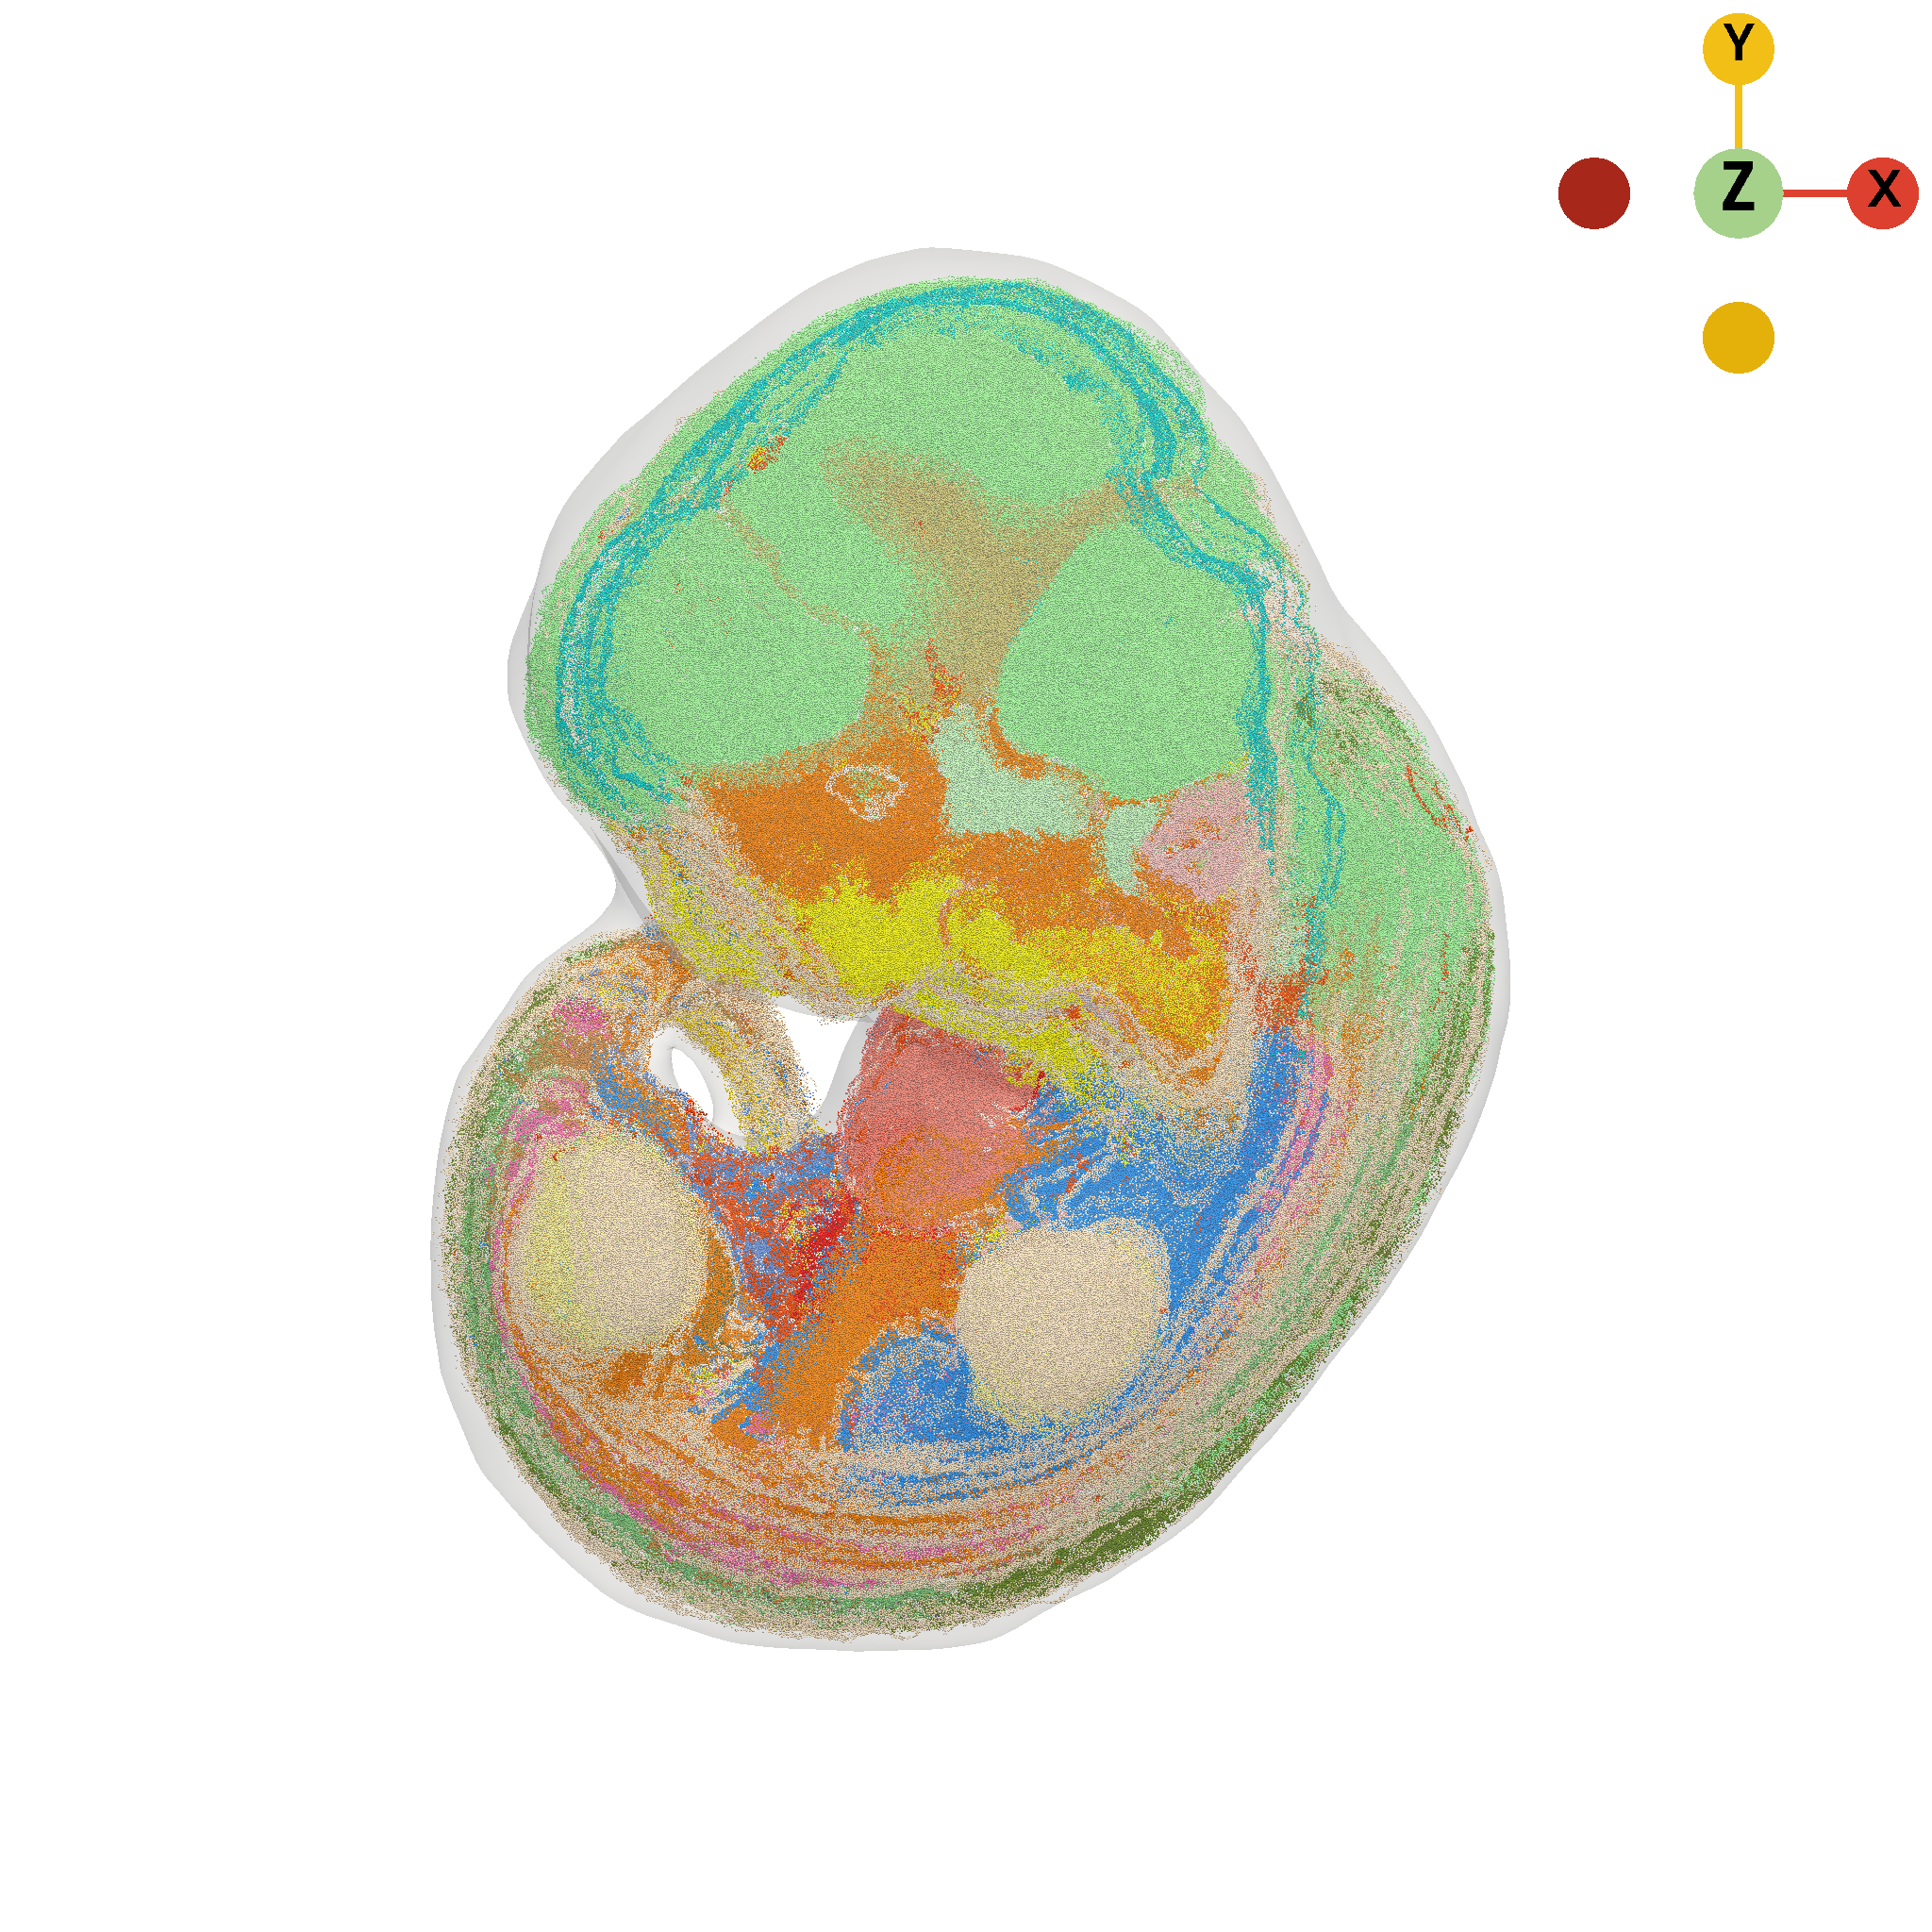

In [4]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([mesh_model, embryo_pc]), 
    key="tissue", 
    model_style=["surface", "points"], 
    opacity=[0.2, 1],
    model_size=2,
    colormap=None,
    show_legend=False,
    show_axes=True,
    jupyter="static",
    cpo="xy",
    window_size=(2048, 2048),
    background='white',
)

In [5]:
import pandas as pd
marker_genes = pd.read_csv("./E11.5_spatial_domain_markers.csv")

In [57]:
import numpy as np
tissue_names = ['Gut tube', 'Spinal cord']
marker_gene_idxs = [0,0]
alpha = np.zeros((embryo_pc.n_points,))
color_rgba = np.ones((embryo_pc.n_points,3))
for tissue_name, marker_gene_idx in zip(tissue_names, marker_gene_idxs):
    marker_gene = marker_genes[tissue_name][marker_gene_idx]
    print(f'---{tissue_name}: {marker_gene}---')
    expression = np.load(f'./marker_genes/{marker_gene}.npy', allow_pickle=True).item()
    expression = expression.A.squeeze()
    norm_expression = expression / expression.max()
    color = embryo_pc['tissue_rgba'][embryo_pc['tissue'] == tissue_name,:][0,:3]
    alpha = np.maximum(alpha, np.maximum(0.05, norm_expression))
    color_rgba = color_rgba * (np.repeat([color], embryo_pc.n_points, axis=0) + np.repeat([1-color], embryo_pc.n_points, axis=0) * (1 - norm_expression[:,None]))
    # expression_rgba = np.concatenate([np.repeat([color], embryo_pc.n_points, axis=0) + np.repeat([1-color], embryo_pc.n_points, axis=0) * (1 - norm_expression[:,None]), np.maximum(0.05, norm_expression)[:,None]], axis=1)
expression_rgba = np.concatenate([color_rgba, alpha[:,None]], axis=1)

embryo_pc.point_data["expression_rgba"] = expression_rgba
embryo_pc.point_data["expression"] = expression

---Gut tube: Peg3---
---Spinal cord: Tubb2b---


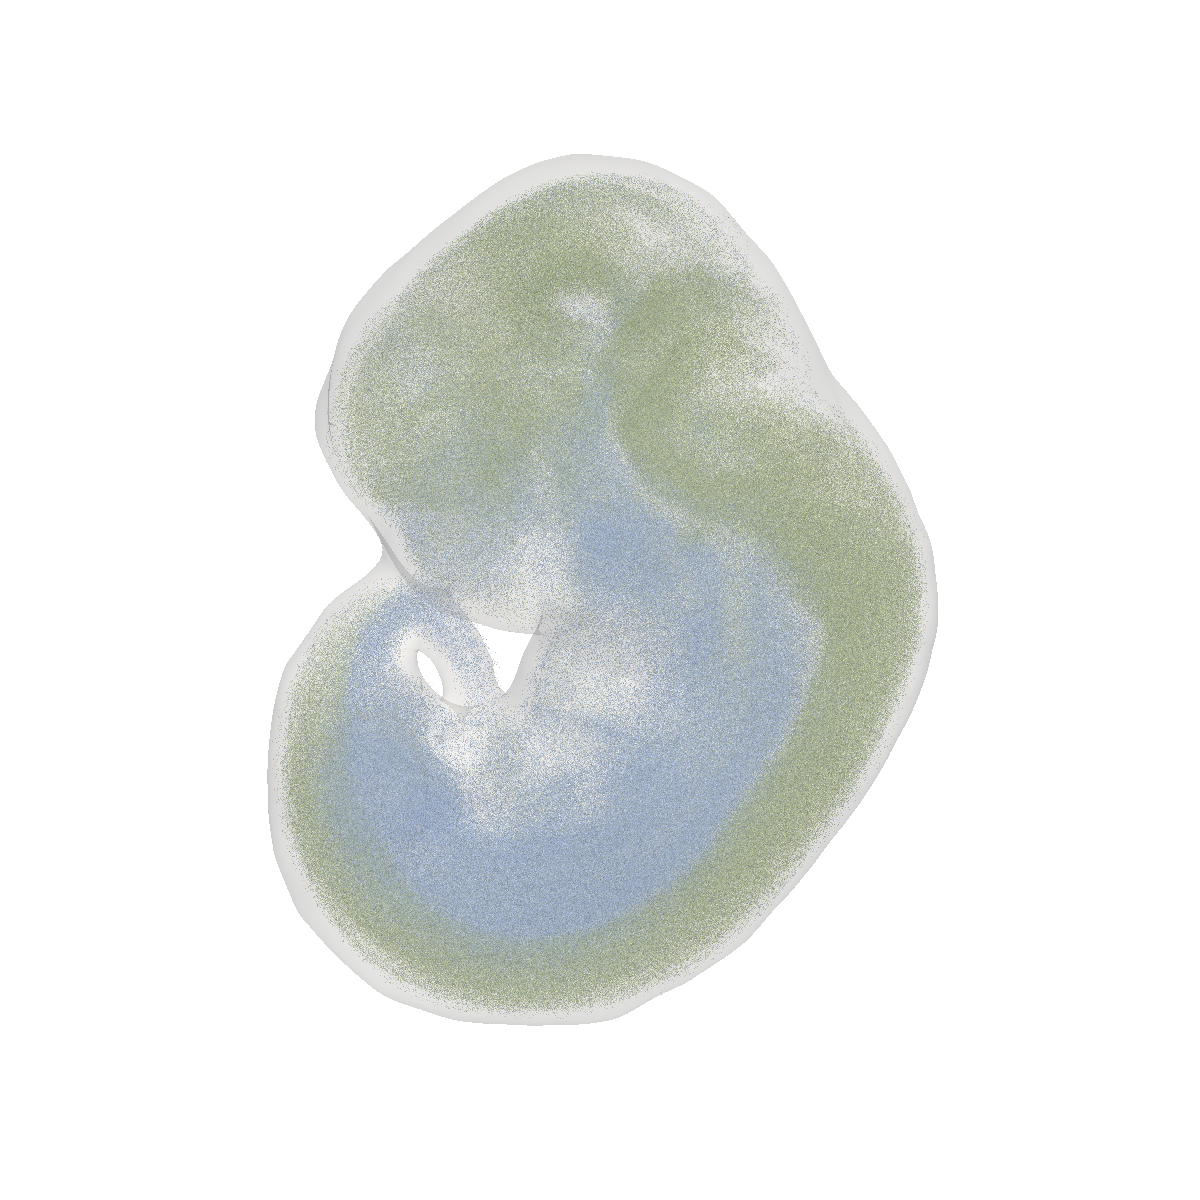

In [58]:
import pyvista as pv
pv.global_theme.transparent_background=False
st.pl.three_d_plot(
    model=st.tdr.collect_models([mesh_model, embryo_pc]), 
    key="expression", 
    model_style=["surface", "points"], 
    opacity=[0.05, 1],
    model_size=1,
    colormap=None,
    show_legend=False,
    # show_axes=False,
    jupyter="static",
    cpo="xy",
    window_size=(1200, 1200),
    background='white',
    ambient=0.2,
    # filename = f"./marker_genes_fig/{'_'.join(tissue_names)}.tiff",
)

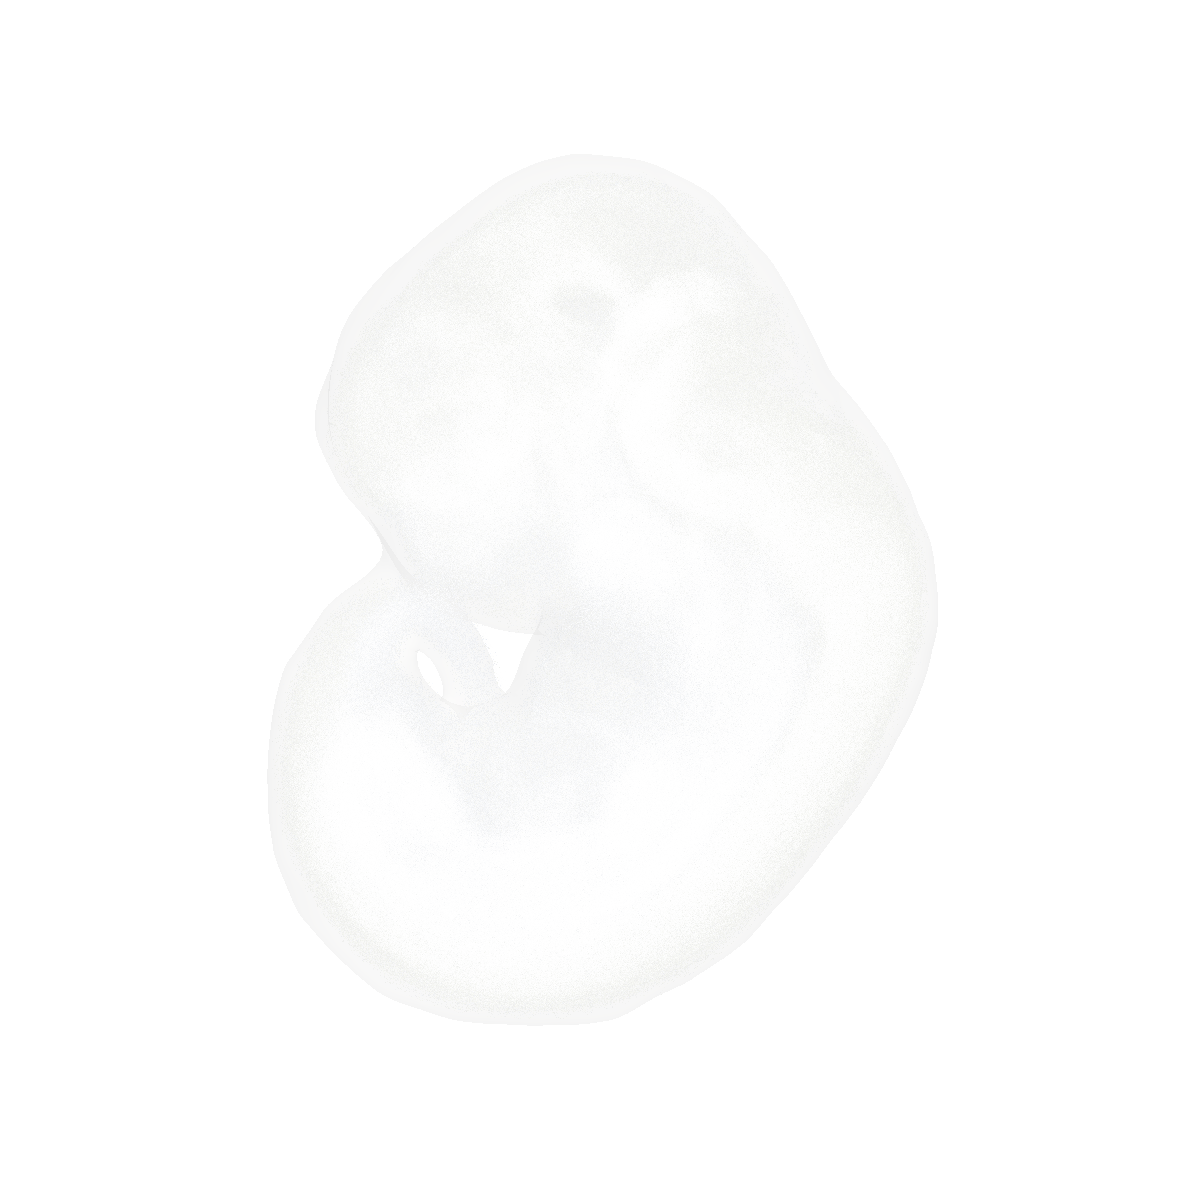

In [59]:
import pyvista as pv
pv.global_theme.transparent_background=True
st.pl.three_d_plot(
    model=st.tdr.collect_models([mesh_model, embryo_pc]), 
    key="expression", 
    model_style=["surface", "points"], 
    opacity=[0.2, 1],
    model_size=1,
    colormap=None,
    show_legend=False,
    # show_axes=False,
    jupyter="static",
    cpo="xy",
    window_size=(1200, 1200),
    background='white',
    ambient=0.2,
    filename = f"./marker_genes_fig/{'_'.join(tissue_names)}.tiff",
)